<h1>Creating RGB composite from Sentinel-2 raw images</h1>

This Jupyter notebook walks you through on the process how an RGB composite can be created from raw Sentinel-2 images. <br>
Raw images can be downloaded from https://scihub.copernicus.eu/ after a free registration. Please note that activation of your account can take 24 hours!


<h2>Preparation</h2>
Let's start with importing the necessary <b>libraries</b>.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import os
from osgeo import gdal

After the libraries are loaded, we have to define the <b>input</b> and <b>output folders</b>. The input folder is where you have to put the <b>downloaded Sentinel-2</b> images. The output folder is where our script will <b>save the RGB composite image</b>.<br>
The input filenames have to be specified as well for each band.

In [2]:
fp_in='input/'
fp_out='output/'

fn_blue='Tihany_T33TYN_A021798_20210509T094028_B02'
fn_green='Tihany_T33TYN_A021798_20210509T094028_B03'
fn_red='Tihany_T33TYN_A021798_20210509T094028_B04'

To work with the Sentinel-2 images, first we have to <b>convert them from '.jp2' to '.tif'</b> file formats, since Rasterio library can only deal with the latter.

In [3]:
bandList = [band for band in os.listdir(fp_in) if band[-4:]=='.jp2']
for band in bandList:
    in_image = gdal.Open(fp_in+band)
    driver = gdal.GetDriverByName("GTiff")
    fp_tif = fp_in+band[:-4]+'.tif'
    out_image = driver.CreateCopy(fp_tif, in_image, 0)
    in_image = None
    out_image = None   

<h2>Creating raw RGB composite</h2>
Let's define the <b>filepath</b> for each converted Sentinel-2 images and open them with Rasterio.

In [4]:
band_02=rasterio.open(fp_in+fn_blue+'.tif')
band_03=rasterio.open(fp_in+fn_green+'.tif')
band_04=rasterio.open(fp_in+fn_red+'.tif')

Now we have to <b>read</b> in the opened files.

In [5]:
red = band_04.read(1)
green = band_03.read(1)
blue = band_02.read(1)

If we look at the red band raster we will see the following:

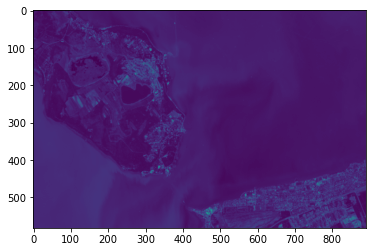

In [6]:
plt.imshow(red)

The blueish image is basically an intensity map, where each pixel represents the amount of reflected light that the Sentinel-2's sensor captured in the red band. The brighter pixels (higher values) represent more red content and the darker pixels (lower values) represent less red content.<br>
<br>
We can change the blueish representation with the 'cmap' command. In the example below I choose 'Reds' representation.<br>
(Note there are many other options as well. For more details please look ath the Matplotlib documentation).

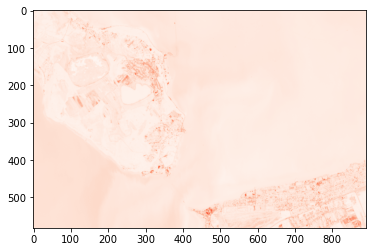

In [7]:
plt.imshow(red, cmap='Reds')

Now let's see how the <b>red, green and blue</b> channel images look like.

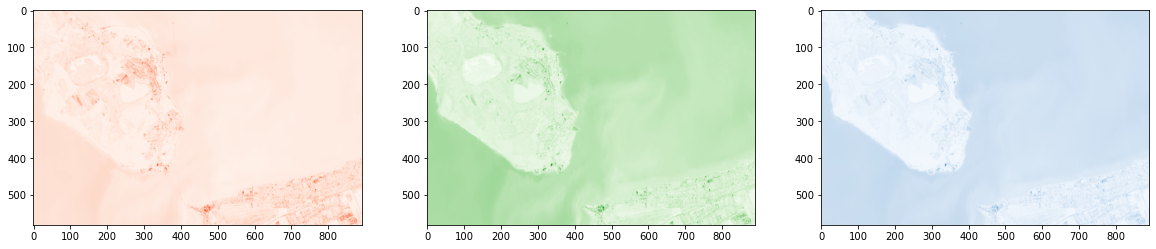

In [8]:
fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(red, cmap='Reds')
ax1 = fig.add_subplot(1,3,2)
ax1.imshow(green, cmap='Greens')
ax1 = fig.add_subplot(1,3,3)
ax1.imshow(blue, cmap='Blues')

You can get the <b>size of the red band image</b> with the  shape command as shown below. <br>
As you can see this image is a 2D array with 582 rows and 981 columns.

In [9]:
red.shape

(582, 891)

To make an RGB composite we have to <b>stack together the Red, Green and Blue band images</b> into one image with the np.dstack command.<br>
If we call again the shape command on the newly created RGB composite we will see, that <b>now we got a 3D array</b> with the red,green and blue channels.

In [10]:
rgb_composite_raw= np.dstack((red, green, blue))
rgb_composite_raw.shape

(582, 891, 3)

Now let's have a look on the RGB image...

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


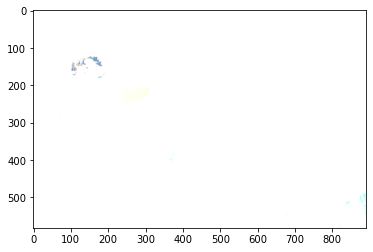

In [11]:
plt.imshow(rgb_composite_raw)

This is not quite what we are looking for, right? The root of the problem is that most images have a pixel value range from 0-255 or 0-1. If we look at the red band's max pixel value we get more than 255.

In [12]:
red.max()

6392

In [13]:
red.min()

103

What can we do now? The solution for this problem is to <b>normalize</b> all of the pixel values between 0..1.

In [14]:
def normalize(band):
    band_min, band_max = (band.min(), band.max())
    return ((band-band_min)/((band_max - band_min)))

red_n = normalize(red)
green_n = normalize(green)
blue_n = normalize(blue)

After noramlizing our image, the max and min values of one band should be 0 and 1.

In [15]:
red_n.max()

1.0

In [16]:
red_n.min()

0.0

Now let's do our RGB stack again and see what results we get.

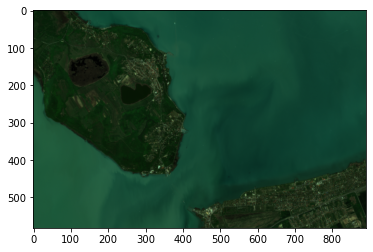

In [17]:
rgb_composite_n= np.dstack((red_n, green_n, blue_n))
plt.imshow(rgb_composite_n)

Finally we can see our area of interest, however the colors seem to be not really realistic and the whole image is a bit dark.<br>

<h2>Basic image manipulation techniques</h2>

To solve this issue, we will have to brighten each band first, then normalize them and do the stacking.<br>
From mathematical point of view, the <b>brightening</b> function multiplies each pixel value with 'alpha' and adds 'beta' value if necessary. <br>
If this operation is done we have to clip the resulted pixel values between 0..255.

In [18]:
def brighten(band):
    alpha=0.13
    beta=0
    return np.clip(alpha*band+beta, 0,255)

red_b=brighten(red)
blue_b=brighten(blue)
green_b=brighten(green)

red_bn = normalize(red_b)
green_bn = normalize(green_b)
blue_bn = normalize(blue_b)

Now let's have a look at the new RGB composite after brightening and normalizing the bands.

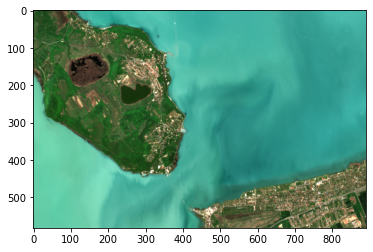

In [19]:
rgb_composite_bn= np.dstack((red_bn, green_bn, blue_bn))
plt.imshow(rgb_composite_bn)

Now our image is looking quite realistic now. Note that this image does not represent the real reflectance values.<br>

Another image manipulation technique is <b>gamma correction</b>. The math behind it is that we take each pixels intesnity values and raise it to the power of (1/gamma) where the gamma value is specified by us.<br>
Let's use our raw images, do the gamma correction and normalization.

In [20]:
def gammacorr(band):
    gamma=2
    return np.power(band, 1/gamma)

red_g=gammacorr(red)
blue_g=gammacorr(blue)
green_g=gammacorr(green)

red_gn = normalize(red_g)
green_gn = normalize(green_g)
blue_gn = normalize(blue_g)

Now let's have a look at the result.

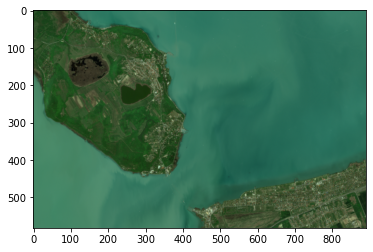

In [21]:
rgb_composite_gn= np.dstack((red_gn, green_gn, blue_gn))
plt.imshow(rgb_composite_gn)

Feel free to play around the values and try for your self what impact they have on the final image.

<h2>Saving the image into PNG</h2>
What most people want to do at this point is to <b>save the image into a file</b>.<br>
This could be done with the following lines of code will save the brightened and normalized image into a PNG file.<br>
Notice that an <b>interpolation method</b> is given to <b>smooth the image</b> and also the <b>dpi value<b> can be controlled.<br>
For more info please visit Pyplot documentation.

In [22]:
rgb_plot=plt.imshow(rgb_composite_bn, interpolation='lanczos')
plt.axis('off')
plt.savefig(fp_out+'tihany_rgb_composite.png',dpi=200,bbox_inches='tight')
plt.close('all')